## Object Detection with Faster R-CNN

Fast R-CNN is a method for object detection that uses region proposal. In this lab, you will use Faster R-CNN pre-trained on the coco dataset. You will learn to detect several objects by name and to use the likelihood of the object prediction being correct.




In [11]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

--2025-12-17 20:19:45--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48572 (47K) [image/jpeg]
Saving to: ‘DLguys.jpeg.2’

DLguys.jpeg.2       100%[===================>]  47.43K   265KB/s    in 0.2s    

2025-12-17 20:19:46 (265 KB/s) - ‘DLguys.jpeg.2’ saved [48572/48572]

--2025-12-17 20:19:46--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Resolving cf-courses-data.s3.us.cloud-ob

In [12]:
import torchvision
from torchvision import transforms
import torch
from torch import no_grad

In [13]:
import requests

In [14]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood is under a thereshold

In [15]:
from typing import List

def get_predictions(
        pred,
        coco_instance_category_names: list,
        threshold: float =.8,
        objects: None | List = None) -> List:
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """
    zip_list_pred = zip(
        list(
            pred[0]['labels'].numpy()),
            pred[0]['scores'].detach().numpy(),
            list(pred[0]['boxes'].detach().numpy()
            )
    )
    predicted_classes: list = [
        (
            coco_instance_category_names[i], p, [
                (
                    box[0],
                    box[1]
                ),
                {
                    box[2],
                    box[3]
                }
            ]
        ) for i, p, box in zip_list_pred 
    ]

    predicted_classes_stuff: list = [stuff for stuff in predicted_classes if stuff[1] > threshold]

    if objects and predicted_classes_stuff:
        return [
            (name, p, box) for name, p, box in predicted_classes_stuff if name in objects
        ]
    return predicted_classes_stuff


In [16]:
def draw_box(
        predicted_classes,
        image,
        rect_th: int = 10,
        text_size: int  = 3,
        text_th: int = 3) -> None:
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img = (
        np.clip(
            cv2.cvtColor(
                np.clip(
                    image.numpy().transpose((1, 2, 0)), 0, 1
                ),
                cv2.COLOR_RGB2BGR), 0, 1
            )*255
        ).astype(np.uint8).copy()

    for predicted_class in predicted_classes:

        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]

        cv2.rectangle(
            img,
            box[0],
            box[1],
            (0, 255, 0),
            rect_th
        )
        cv2.putText(
            img,
            label,
            box[0],
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0, 255, 0),
            thickness=text_th
        )
        cv2.putText(
            img,
            label+": "+str(round(probability, 2)),
            box[0],
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0,255,0),
            thickness=text_th
        )
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BAYER_BG2RGB))
    del(img)
    del(image)

In [17]:
# def save_RAM(image_=False):
#     global image, img, pred
#     torch.cuda.empty_cache()
#     del(img)
#     del(pred)
#     if image_:
#         image.close()
#         del(image)

# Load Pre-trained Faster R-CNN

Faster R-CNN is a model that predicts both bounding boxes and class scores for potencial objetcs in the image pre-trained on COCO



In [18]:
T1_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)
T1_model.eval()


for name, param in T1_model.named_parameters():
    param.requires_grad = False

print('Done')


/home/machine01/.cache/pypoetry/virtualenvs/cognitiveclass-computer-vision-hands-on-wi-KamljRSP-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/machine01/.cache/pypoetry/virtualenvs/cognitiveclass-computer-vision-hands-on-wi-KamljRSP-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [19]:
def model(x):
    with torch.no_grad():
        yhat = T1_model(x)
    return yhat

In [20]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__',
    'person',
    'bicycle',
    'car',
    'motorcycle', 
    'airplane', 
    'bus',
    'train',
    'truck',
    'boat', 
    'traffic light',
    'fire hydrant',
    'N/A',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog', 
    'horse', 
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'N/A', 
    'backpack', 
    'umbrella', 
    'N/A', 
    'N/A',
    'handbag',
    'tie',
    'suitcase', 
    'frisbee', 
    'skis', 
    'snowboard', 
    'sports ball',
    'kite', 
    'baseball bat',
    'baseball glove', 
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'N/A',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana', 
    'apple',
    'sandwich',
    'orange',
    'broccoli', 
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair', 
    'couch',
    'potted plant',
    'bed',
    'N/A',
    'dining table',
    'N/A',
    'N/A',
    'toilet',
    'N/A',
    'tv', 
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink', 'refrigerator', 'N/A', 'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear', 
    'hair drier',
    'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

# Object Localization

In Object Localization we locate the presence of object in an image indicate the locais with a bounding box. Consider the image of Geoffrey Hinto

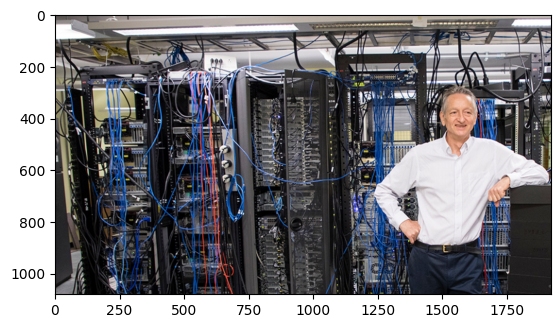

In [23]:
img_path: str = "jeff_hinton.png"
half: float = .5
image = Image.open(img_path)
image.resize(
    [
        int(half * s) for s in image.size
    ]
)

plt.imshow(image)
plt.show()

In [24]:
# We illl create a transform object to convert the image to a tensor

transform = transforms.Compose(
    transforms.ToTensor()
)



In [29]:
img = transform(image)

TypeError: 'ToTensor' object is not iterable

In [26]:
pred = model([img])

NameError: name 'img' is not defined

In [27]:
pred[0]['labels']

NameError: name 'pred' is not defined

pred[0]['scores']